# aSPEM Experiment : analysis

TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run ../0_parameters.ipynb


WELCOME

2020-01-31T13:39:07+01:00

CPython 3.5.2
IPython 5.3.0

numpy 1.16.3
matplotlib 3.0.3
torch 1.1.0

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-83-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
host name  : INV-OPE-HP01
Git hash   : 01b0b8a61c50a2ebb239b6507c1979ae84d1d68a
Git repo   : https://github.com/chloepasturel/AnticipatorySPEM.git
Git branch : master


In [2]:
import pickle
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

## find best h

In [5]:
def best_h(exp, max_tau) :

    # see notebook dev/2019_07_10_test_harzardrate
    def pred_score(o, p_hat):
        score = o * np.log2(p_hat) + (1-o) * np.log2(1-p_hat)
        return score

    best_h = []
    
    N_blocks = exp['N_blocks']
    p = exp['p']
    tau = np.arange(1, max_tau, 1)
    hs = 1/tau
    
    score = []
    for i_scan, h_ in enumerate(hs):
        
        
        p_hat = np.zeros(600)
        o_suj = np.zeros(600)
        for i_block in range(N_blocks):
            
            o = p[:, i_block, 0] # observations
            p_true = p[:, i_block, 1]

            p_hat_b = np.zeros(200)

            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(o[liste[a]:liste[a+1]], h=h_)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')

                p_hat_b[liste[a]:liste[a+1]] = p_hat_p
            
            p_hat[i_block*200:(i_block+1)*200] = p_hat_b
            o_suj[i_block*200:(i_block+1)*200] = o
            
        score.append(np.mean(pred_score(o_suj, p_hat)))

    best_h = hs[np.argmax(score)]
        
    return best_h

In [6]:
def mask_nan(h_va, h_bet, r_va, r_bet) :
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_bet)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_bet)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_bet)).compressed()

    r_bet = np.ma.masked_array(r_bet, mask=np.isnan(h_va)).compressed()
    h_bet = np.ma.masked_array(h_bet, mask=np.isnan(h_va)).compressed()
    
    r_va = np.ma.masked_array(r_va, mask=np.isnan(h_va)).compressed()
    h_va = np.ma.masked_array(h_va, mask=np.isnan(h_va)).compressed()
    
    return h_va, h_bet, r_va, r_bet

In [7]:
def maxx_pourcentage(r_, pourcentage) :
    maxx=None
    for round_ in list(reversed(np.arange(5))) :
        if maxx is None :
            for x in range(len(r_)) :
                if np.round(r_[x], round_)==np.round(pourcentage*np.max(r_), round_) :
                    maxx=x
    return maxx

In [8]:
def print_stat(h) :
    from scipy import stats
    
    print('\n\t\t\tmannwhitneyu', '\tkruskal', '\t\tks_2samp', sep='')
    print('\t\t\t','-'*12, '\t', '-'*7, '\t\t', '-'*8, sep='')
    
    def stata(h1, h2) :
        man = stats.mannwhitneyu(h1, h2).pvalue
        kr = stats.kruskal(h1, h2).pvalue
        ks = stats.ks_2samp(h1, h2).pvalue
        print('%.4f'%man, '%.4f'%kr, '%.4f'%ks, sep='\t\t')
        return man, kr, ks
    
    list_signi = []
    for b1 in range(2) :
        for b2 in range(1, 3) :
            if b1!=b2 :
                print('BLOCK %s vs %s'%(b1,b2), end=' :\t\t')
                man, kr, ks = stata(h['b'][b1], h['b'][b2])
                for s in [man, kr, ks] :
                    if s < 0.05 : list_signi.append('B %s-%s'%(b1,b2)) ; break
    print('\nSignificatif :', list_signi)

In [9]:
suj = ['AM', 'BMC', 'CS', 'DC', 'FM', 'IP', 'LB', 'OP', 'RS', 'SR',  'TN', 'YK']

In [31]:
def plot_fig(recording, max_tau=None, coupe=[1/500, 1/200],
             color_min_max=['k', 'k'], pourcentage=None, ls=None,
             v_line_supp=None, fig_width=15) :
    
    
    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:max_tau]
    #c_block = ['olive', 'peru', 'brown']
    c_sujet = ['k']
    
    fig, ax_ = plt.subplots(1, 1, figsize=(fig_width,fig_width))
    import matplotlib.gridspec as gridspec

    
    # DECO
    #---------------------------------------------------------------
    lim = (min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
    ax_.set_xlim(lim)     ; ax_.set_ylim(lim)
    ax_.set_xscale("log") ; ax_.set_yscale("log")
    
    # LABEL
    ax_.set_xlabel(r'$h_{\mathrm{aSPEM}}$', fontsize=t_label) ; ax_.set_ylabel(r'$h_{\mathrm{bet}}$', labelpad=-20, fontsize=t_label)
    opt = dict(fontsize=t_label/2.7)
    ax_.set_title('', fontsize=0)
    
    # tick
    ax_.tick_params(labelsize=t_label/2.7, length=7, which='major') ; ax_.tick_params(length=5, which='minor')
    
    #---------------------------------------------------------------
    h_va, h_bet, r_va, r_bet = [],[],[],[]
        
    #---------------------------------------------------------------
    for num, s in enumerate(suj) :
        
        print(s, end=' ')

        h_va_s, h_bet_s, r_va_s, r_bet_s = [], [], [], []
        r_va_d, r_bet_d = recording['r_va'][s][:max_tau], recording['r_bet'][s][:max_tau]

        r_va_s.append(np.max(r_va_d))   ; h_va_s.append(list_h[np.argmax(r_va_d)])
        r_bet_s.append(np.max(r_bet_d)) ; h_bet_s.append(list_h[np.argmax(r_bet_d)])

        #-----------------------------------------------------------------------           
        opt = dict(alpha=0.6, lw=0, edgecolors='k') # c=COLOR[num], lw=3
        ax_.scatter(h_va_s, h_bet_s, s=(np.array(r_va_s)*np.array(r_bet_s))*600,
                    c=c_sujet, zorder=50, **opt)

        #-----------------------------------------------------------------------
        h_va.extend(h_va_s) ; h_bet.extend(h_bet_s) ; r_va.extend(r_va_s) ; r_bet.extend(r_bet_s)
    
    h_va, h_bet, r_va, r_bet = mask_nan(h_va, h_bet, r_va, r_bet)
    r_va, r_bet = np.array(r_va), np.array(r_bet)

    ratio = np.array(h_bet)/np.array(h_va)    
    print('\n\nRATIO h_bet/h_va =', np.mean(ratio), '+/-', np.std(ratio))
    ratio = np.array(h_va)/np.array(h_bet)    
    print('RATIO h_va/h_bet =', np.mean(ratio), '+/-', np.std(ratio))
    
    
    # lines
    #--------------------------------------------------------------------------------------------
    ax_.plot(np.arange(-10,10), np.arange(-10,10), '-k', alpha=0.2, lw=1.5)
    #colors = 'teal'
    
    opt=dict(colors=color_bcp_mean, linestyles='-', alpha=0.7, linewidth=1.5)
    ax_.vlines(0.025, -10, 10, **opt) ; ax_.hlines(0.025, -10, 10, **opt) #, label='h$_{true}$'
    ax_.text(10**(-3), 0.025, 'h$_{true}$ = 1/40\n', color=color_bcp_mean, fontsize=t_label/3)
    
    
    mimi_va, mimi_bet = np.nanmedian(h_va), np.nanmedian(h_bet)
    opt=dict(colors='k', alpha=0.8, lw=1.5)#, linestyles=(3.5,[4, 2, 4, 2]))
    ax_.vlines(mimi_va, 0, 10, **opt) ; ax_.hlines(mimi_bet, 0, 10, **opt) #, label='median'
    ax_.text(mimi_va, 10**(-0.2), '   median h$_{aSPEM}$ = 1/%s'%int(1/mimi_va), color='k', fontsize=t_label/3)
    ax_.text(10**(-0.8), mimi_bet,  'median h$_{bet}$ = 1/%s\n'%int(1/mimi_bet), color='k', fontsize=t_label/3)
    
    
    opt=dict(alpha=0.8, lw=1.5)
    if v_line_supp is not None :
        for i, l in enumerate(v_line_supp['lines']) :
            opt['colors'] = v_line_supp['colors'][i]
            ax_.vlines(l, 0, 10, **opt) ; ax_.hlines(l, 0, 10, **opt) # label=v_line_supp['name'][i],
            ax_.text(10**(-3), l, v_line_supp['name'][i], color=v_line_supp['colors'][i], fontsize=t_label/3)
    
    
    if h_va.min() < h_bet.min() : h_min = h_va.min()  ; o_min = 'v'
    else :                        h_min = h_bet.min() ; o_min = 'h'
    if h_va.max() > h_bet.max() : h_max = h_va.max()  ; o_max = 'v'
    else :                        h_max = h_bet.max() ; o_max = 'h'
    
    for h, orientation, c, n in zip([h_min, h_max], [o_min, o_max],
                                    [color_min_max[0], color_min_max[1]], ['min', 'max']) :
        
        opt['colors'] = c
        if orientation=='v' :
            ax_.vlines(h, 0, 10, **opt) # , label='h = 1/%s'%int(1/h)
            ax_.text(h+0.005, 10**(-3), 'h$_{%s}$ = 1/%s'%(n, int(1/h)), color=c, fontsize=t_label/3)
        else :
            ax_.hlines(h, 0, 10, **opt) #, label='h = 1/%s'%int(1/h)
            ax_.text(10**(-3), h, 'h$_{%s}$ = 1/%s\n'%(n, int(1/h)), color=c, fontsize=t_label/3)
    
    #--------------------------------------------------------------------
    # Legend
    opt_l = dict(fontsize=t_label/2.7, framealpha=0)#, handlelength=0.6, handletextpad=0.2)
    ax_.legend(loc=2, bbox_to_anchor=(0.05, 0.95, 0., 0.) ,**opt_l)
    #--------------------------------------------------------------------------------------------
    
    
    
    plt.show()
    '''#--------------------------------------------------------------------------------------------
    # STAT
    #--------------------------------------------------------------------------------------------
    from scipy import stats
    print('h_va/h_bet :', stats.wilcoxon(h_va, h_bet))
    _, _, r, _, _ = stats.linregress(h_va, h_bet)
    print('h_va/h_bet : r =', r)
    
    for h, r, title in zip([h_va, h_bet], [r_va, r_bet], [r'$h_{\mathrm{aSPEM}}$', r'$h_{\mathrm{bet}}$']) :
        print('\n\n', '-'*64,'\n%s\n'%title, '-'*64, sep='')        
        h = list(h)
        print('median', np.nanmedian(h),
              '\n25%', np.quantile(h, 0.25),
              '\n75%', np.quantile(h, 0.75))
        print_stat(h)
    #--------------------------------------------------------------------------------------------'''
    fig.tight_layout()

    return fig, h_min, h_max

In [11]:
import glob
import pickle
for fname in glob.glob('../data/pari*pkl'):
    l = fname.split('/')[2].split('.')[0].split('_')
    if l[1]=='AM' :
        a = '../data/pari_AM_%s.pkl'%(l[2]+'_'+l[3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp = b
max_tau=1601
score_max = best_h(exp, max_tau)

In [12]:
v_line_supp = {}
v_line_supp['name'] = ['h$_{score max}$ = 1/%s\n'%int(1/score_max)]
v_line_supp['lines'] = [score_max]
v_line_supp['colors'] = ['grey'] #['olive', 'peru', 'brown']

best_h : [0.05555555555555555]


No handles with labels found to put in legend.


AM BMC CS DC FM IP LB OP RS SR TN YK 

RATIO h_bet/h_va = 0.7057796597230969 +/- 0.5789805707708482
RATIO h_va/h_bet = 14.079874283913922 +/- 39.661305592251594


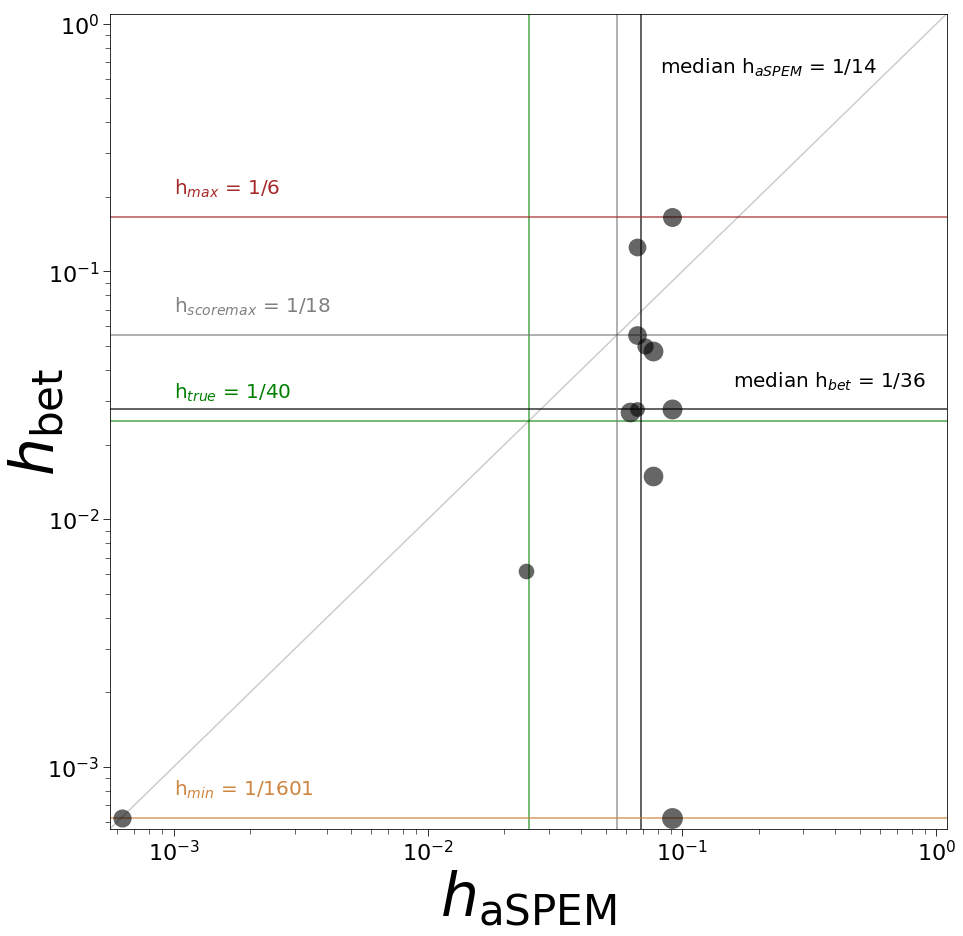

In [32]:
'''file = os.path.join('../parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')'''

file = os.path.join('../parametre', 'list_h_sujet.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')

    
fig_width_f = fig_width/2
ls =   [(0,[3*i,2,3*i,2]) for i in range(1, 13)]
opt = dict(max_tau=max_tau, ls=ls, color_min_max=['peru', 'brown'], fig_width=fig_width_f)
print('best_h :', v_line_supp['lines'])

fig, h_min, h_max = plot_fig(recording, v_line_supp=v_line_supp,  **opt)
fig.savefig('figures/figure_5A.pdf')

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


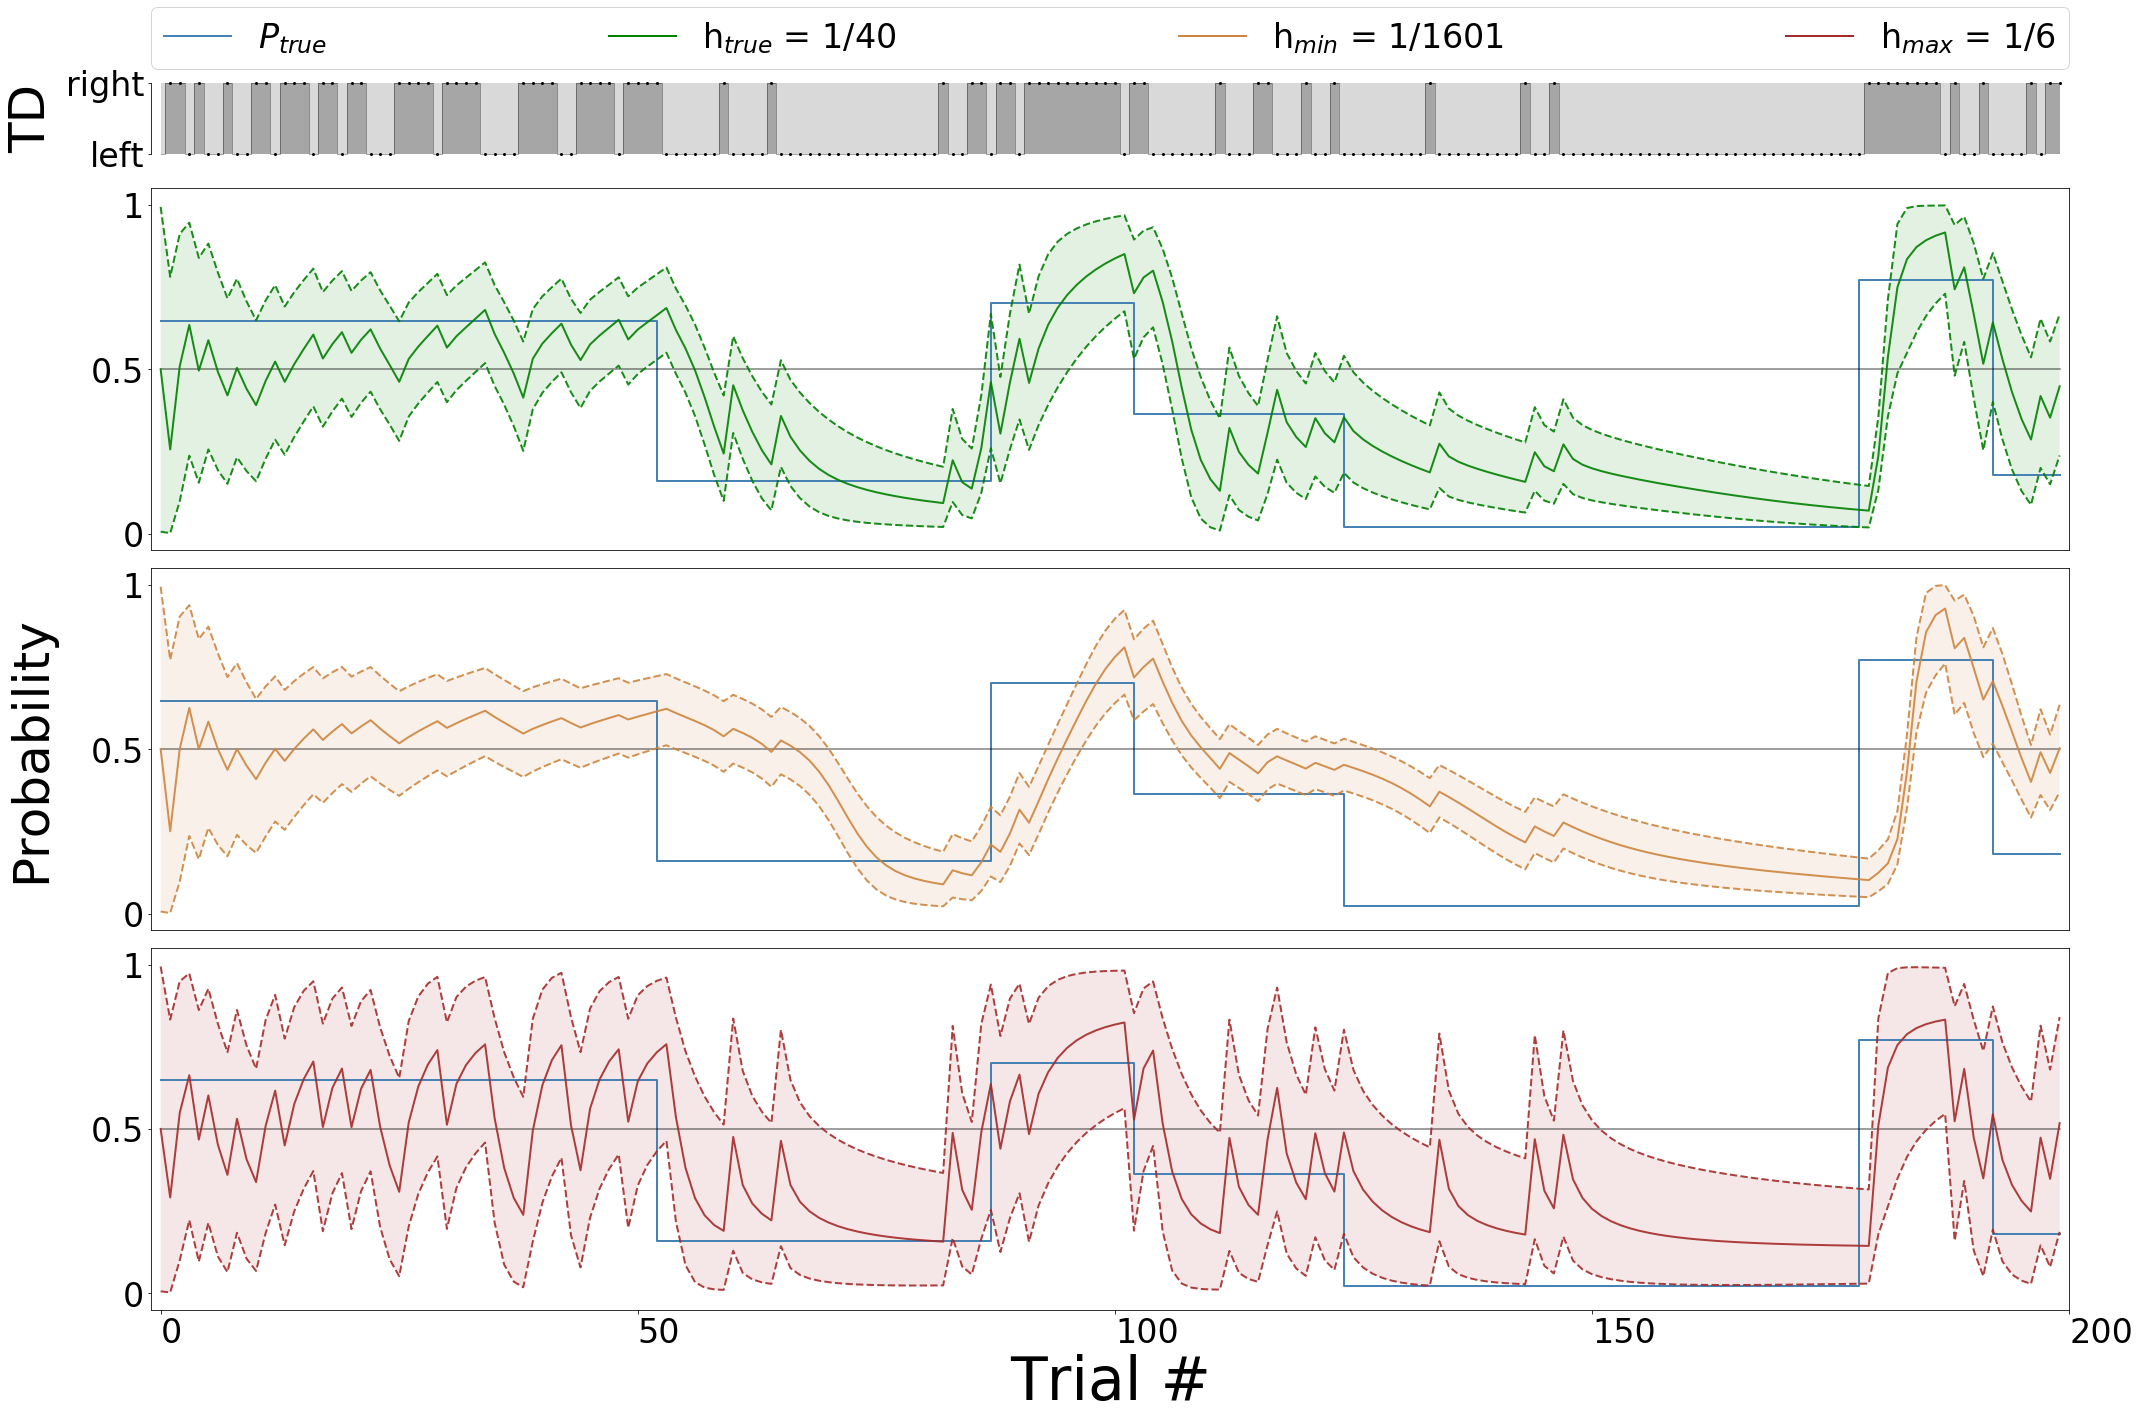

In [33]:
from aSPEM import Analysis
e = Analysis(observer=None, mode='pari', name_file_fit='fct_velocity_sigmo')

num_block = [0]#, 1,2]

t_label_f = t_label
fig_width_f = fig_width #2*(fig_width/3)

color=[['k', 'k'], [color_true_p, color_true_p], ['k','none']]
alpha = [[.35,.15],[.0,.0],[1,0]]
color_bcp=[color_bcp_mean, 'peru', 'brown']
name_bcp=['h$_{true}$', 'h$_{min}$', 'h$_{max}$']
opt = dict(num_block=num_block, color_bcp=color_bcp, name_bcp=name_bcp,
           color=color,alpha=alpha, titre='', t_label=t_label_f, lw=2, fig_width=fig_width_f) 

fig, axs = e.plot_FIG5B(list_h=[1/40, h_min, h_max], pause=None, **opt)
plt.tight_layout()
fig.savefig('figures/figure_5B.pdf')

In [35]:
fig.get_size_inches()[1]

21.631644004944373

best_h : [0.05555555555555555]


No handles with labels found to put in legend.


AM BMC CS DC FM IP LB OP RS SR TN YK 

RATIO h_bet/h_va = 0.7057796597230969 +/- 0.5789805707708482
RATIO h_va/h_bet = 14.079874283913922 +/- 39.661305592251594


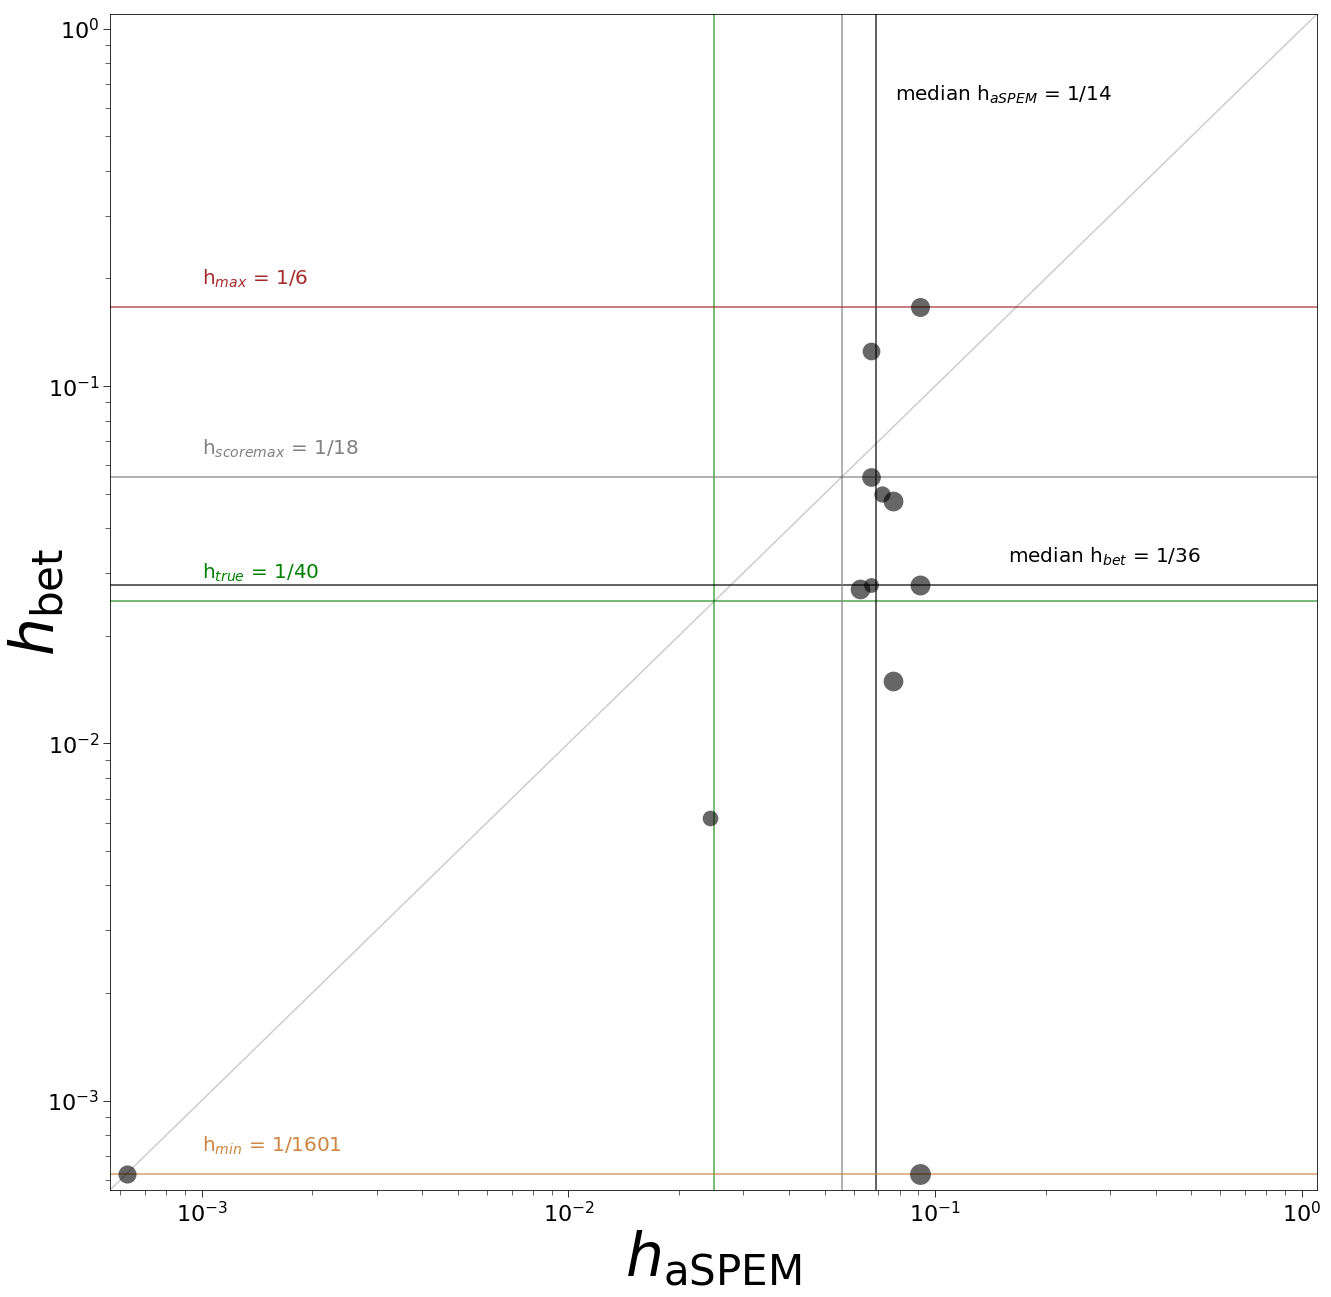

In [36]:
'''file = os.path.join('../parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')'''

file = os.path.join('../parametre', 'list_h_sujet.pkl')
with open(file, 'rb') as fichier : recording = pickle.load(fichier, encoding='latin1')

    
fig_width_f = fig.get_size_inches()[1]
ls =   [(0,[3*i,2,3*i,2]) for i in range(1, 13)]
opt = dict(max_tau=max_tau, ls=ls, color_min_max=['peru', 'brown'], fig_width=fig_width_f)
print('best_h :', v_line_supp['lines'])

fig, h_min, h_max = plot_fig(recording, v_line_supp=v_line_supp,  **opt)
fig.savefig('figures/figure_5A.pdf')